In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import time

# Check if TensorFlow detects the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs detected:", gpus)
else:
    print("No GPU detected")

# Function to perform a simple matrix multiplication on the specified device
def run_matrix_multiplication(device):
    with tf.device(device):
        a = tf.random.normal([1000, 1000])
        b = tf.random.normal([1000, 1000])
        
        start_time = time.time()
        c = tf.matmul(a, b)
        _ = c.numpy()  # Force the computation to be executed
        end_time = time.time()
        
        print(f"Matrix multiplication on {device} took {end_time - start_time:.4f} seconds")

# Run matrix multiplication on CPU
print("Running on CPU:")
run_matrix_multiplication('/CPU:0')

# Run matrix multiplication on GPU (if available)
if gpus:
    print("Running on GPU:")
    run_matrix_multiplication('/GPU:0')
else:
    print("GPU not available, skipping GPU test.")

2024-06-09 12:21:43.379642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 12:21:43.379694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 12:21:43.381148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Running on CPU:
Matrix multiplication on /CPU:0 took 0.0493 seconds
Running on GPU:
Matrix multiplication on /GPU:0 took 0.0235 seconds


In [3]:
train_df = pd.read_csv('/kaggle/input/birdclef-2024/train_metadata.csv')
relation_df = pd.read_csv('/kaggle/input/birdclef-2024/eBird_Taxonomy_v2021.csv')

In [4]:
train_df.tail()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
24454,zitcis1,[],[''],43.5925,4.5434,Cisticola juncidis,Zitting Cisticola,Chèvremont Fabian,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/845747,zitcis1/XC845747.ogg
24455,zitcis1,[],[''],43.5925,4.5434,Cisticola juncidis,Zitting Cisticola,Chèvremont Fabian,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/845817,zitcis1/XC845817.ogg
24456,zitcis1,[],[''],51.1207,4.5607,Cisticola juncidis,Zitting Cisticola,Wim Jacobs,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/856176,zitcis1/XC856176.ogg
24457,zitcis1,[],[''],41.5607,-8.4236,Cisticola juncidis,Zitting Cisticola,Jorge Leitão,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://xeno-canto.org/856723,zitcis1/XC856723.ogg
24458,zitcis1,[],[''],13.7747,100.8919,Cisticola juncidis,Zitting Cisticola,Sam Hambly,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/858550,zitcis1/XC858550.ogg


### Load and decode audio data

# Detect Number of channel in audio file

In [5]:
import tensorflow as tf
import tensorflow_io as tfio

# Function to load an OGG file
def load_ogg_audio(filename):
    # Read the file
    # Decode the OGG file
    audio_data = tfio.audio.AudioIOTensor(filename)
    return audio_data

# Replace 'your_audio_file.ogg' with your actual OGG audio file path
audio = load_ogg_audio('/kaggle/input/birdclef-2024/train_audio/asbfly/XC164848.ogg')

# Convert the audio tensor to a numpy array


In [6]:
audio

<AudioIOTensor: shape=[505731      1], dtype=<dtype: 'float32'>, rate=32000>

### Spectogram

In [7]:
audio_slice = audio[:96000]

# No need to squeeze
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

In [8]:
audio_tensor

<tf.Tensor: shape=(96000,), dtype=float32, numpy=
array([-2.5839707e-05,  9.0616373e-07, -6.0544044e-06, ...,
        1.8537400e-03,  2.7523502e-03,  2.0971624e-03], dtype=float32)>

In [9]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

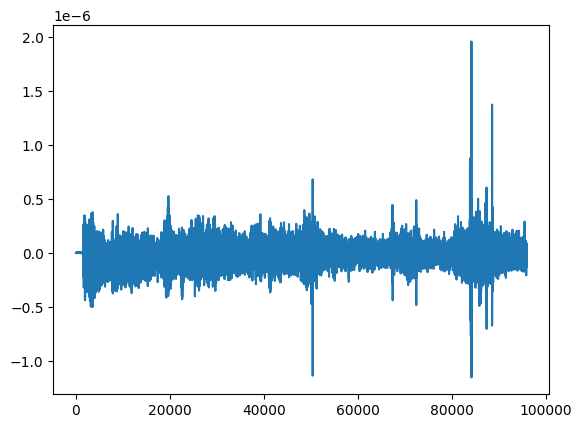

In [10]:
import matplotlib.pyplot as plt


tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())

In [11]:
tensor

<tf.Tensor: shape=(96000,), dtype=float32, numpy=
array([-7.8856527e-10,  2.7653923e-11, -1.8476576e-10, ...,
        5.6571654e-08,  8.3995062e-08,  6.4000318e-08], dtype=float32)>

In [12]:
min_value = tf.reduce_min(tensor)

# Get the maximum value
max_value = tf.reduce_max(tensor)

print("Minimum value:", min_value.numpy())
print("Maximum value:", max_value.numpy())

Minimum value: -1.1551969e-06
Maximum value: 1.959636e-06


tf.Tensor([19575 88701], shape=(2,), dtype=int64)
tf.Tensor(19575, shape=(), dtype=int64) tf.Tensor(88701, shape=(), dtype=int64)


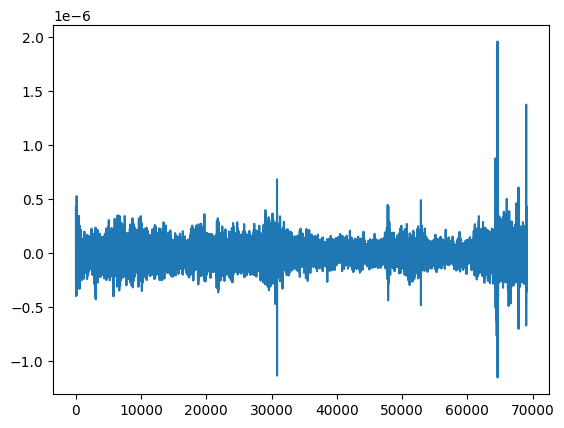

In [13]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.0000004)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())

# Fading the audio signal 

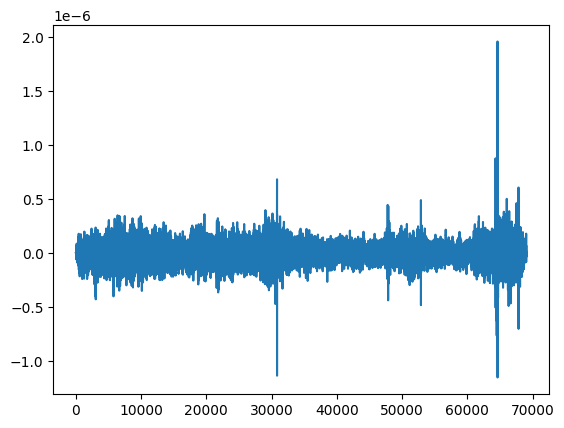

In [14]:
fade = tfio.audio.fade(
    processed, fade_in=1000, fade_out=1000, mode="logarithmic")

plt.figure()
plt.plot(fade.numpy())

# Spectogram Visualization

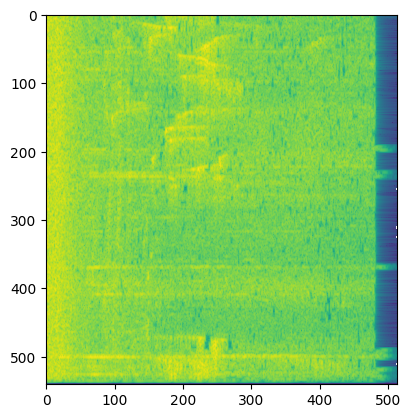

In [15]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(
    fade, nfft=1024, window=1024, stride=128)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

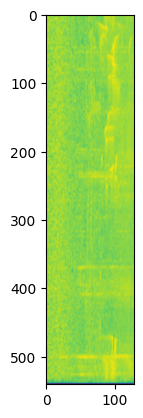

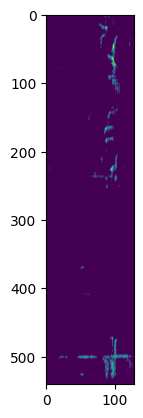

In [16]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=18000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

In [17]:
#spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=2048, window=2048, stride=512)

# Frequency Distribution of each  birds category

In [18]:
import matplotlib.pyplot as plt
import seaborn as sbn

In [19]:
category_counts = train_df['primary_label'].value_counts()

In [20]:
category_counts

primary_label
hoopoe     500
grewar3    500
houspa     500
blrwar1    500
grnsan     500
          ... 
wynlau1      6
blaeag1      6
asiope1      5
niwpig1      5
integr       5
Name: count, Length: 182, dtype: int64

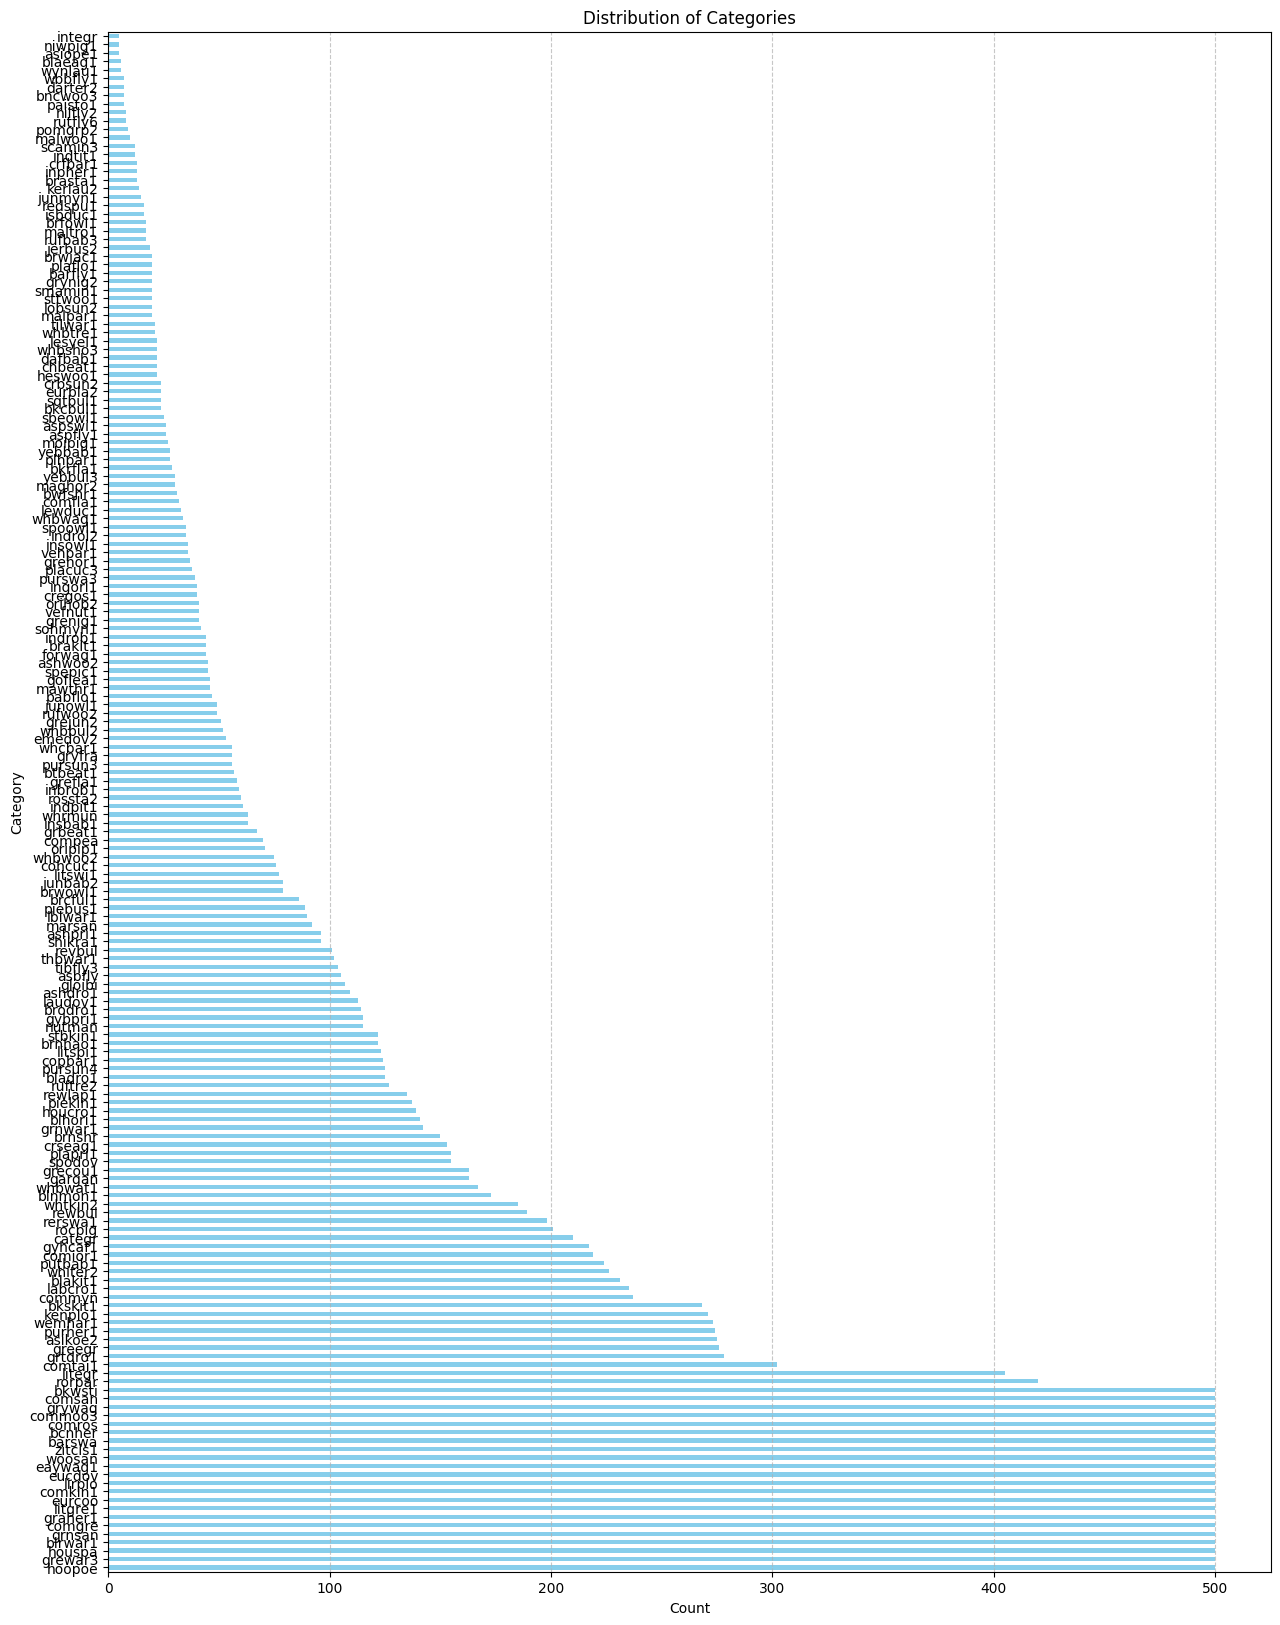

In [21]:


# Plotting the horizontal bar chart
plt.figure(figsize=(15,20 ))
category_counts.plot(kind='barh', color='skyblue')
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Distribution of Categories')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [22]:
len(train_df['primary_label'].unique())

182

In [23]:
relation_df.head(5)

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN


In [24]:
relation_df['CATEGORY'].unique()

array(['species', 'slash', 'issf', 'spuh', 'hybrid', 'domestic', 'form',
       'intergrade'], dtype=object)

In [25]:
relation_df['SPECIES_CODE'].unique()

array(['ostric2', 'ostric3', 'y00934', ..., 'saltat1', 'passer1', 'bird1'],
      dtype=object)

In [26]:
relation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16753 entries, 0 to 16752
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TAXON_ORDER       16753 non-null  int64 
 1   CATEGORY          16753 non-null  object
 2   SPECIES_CODE      16753 non-null  object
 3   PRIMARY_COM_NAME  16753 non-null  object
 4   SCI_NAME          16753 non-null  object
 5   ORDER1            16751 non-null  object
 6   FAMILY            16740 non-null  object
 7   SPECIES_GROUP     216 non-null    object
 8   REPORT_AS         3876 non-null   object
dtypes: int64(1), object(8)
memory usage: 1.2+ MB


# Configuration

In [27]:
import os
class CFG:
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 32
    
    # Audio duration, sample rate, and length
    duration = 5 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 5
    preset = 'efficientnetv2_b2_imagenet'
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2024/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

In [28]:
BASE_PATH = '/kaggle/input/birdclef-2024'

In [29]:
train_df['file_path'] = BASE_PATH + '/train_audio/' + train_df.filename
train_df['target']  = train_df.primary_label.map(CFG.name2label)

In [30]:
train_df.columns

Index(['primary_label', 'secondary_labels', 'type', 'latitude', 'longitude',
       'scientific_name', 'common_name', 'author', 'license', 'rating', 'url',
       'filename', 'file_path', 'target'],
      dtype='object')

In [31]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import tensorflow_io as tfio
  # "jax" or "tensorflow" or "torch" 

import keras_cv
import keras



# Preprocessing

In [32]:
file_path_tensor = tf.constant(train_df['file_path'].values)
target_tensor = tf.constant(train_df['target'].values)

In [33]:
#dataset = tf.data.Dataset.from_tensor_slices((file_path_tensor,target_tensor))

In [34]:
# dataset = dataset.shuffle(1024, seed=123)
# dataset = dataset.batch(32, drop_remainder=True);
# dataset  = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [35]:
# sample_ds = dataset.take(2)
# it = iter(sample_ds)
# print(next(it))

In [36]:
@tf.function
def min_max_normalize(audio):
    max_val = tf.reduce_max(audio)
    min_val = tf.reduce_min(audio)
    return (audio - min_val) / (max_val - min_val) * 2.0 - 1.0

In [37]:
# def calculate_energy(audio, window_size=0.02):
#     # Calculate energy of audio signal using sliding window approach
#     audio = tf.expand_dims(audio, axis=0)
#     window_length = int(window_size * audio.shape[0])
#     # Square the audio signal
#     squared_audio = tf.square(audio)
#     # Calculate the energy of the audio signal using a sliding window approach
#     energy = tf.nn.conv1d(squared_audio, tf.ones((window_length, 1, 1)), stride=1, padding='VALID')
#     return energy

# def determine_threshold(energy, percentile=90):
#     # Determine threshold based on energy distribution
#     threshold = tfp.stats.percentile(energy, percentile)
#     return threshold


In [38]:
@tf.function
def trim_audio(audio, threshold=0.1):
       # Calculate the energy of the audio signal
    energy = tf.reduce_sum(tf.square(audio), axis=-1)

    # Find the start and end indices of the active audio segments
    start_idx = tf.argmax(energy > threshold)
    end_idx = tf.argmax(energy[::-1] > threshold)

    # Trim the audio signal
    trimmed_audio = audio[start_idx:-end_idx]
    #print(trimmed_audio)
    return trimmed_audio

In [39]:
@tf.function
def crop_or_pad(audio, target_len, pad_mode="constant"):
    audio = tf.reshape(audio, [-1])  # Ensure audio is a 1-D tensor
    audio_len = tf.shape(audio)[0]
    
    diff_len = tf.abs(target_len - audio_len)  # Find difference between target and audio length
    
    if audio_len < target_len:  # Do padding if audio length is shorter
        pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
        pad2 = diff_len - pad1
        audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
    elif audio_len > target_len:  # Do cropping if audio length is larger
        idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
        audio = audio[idx : (idx + target_len)]
    
    return tf.reshape(audio, [target_len])

In [40]:
@tf.function
def apply_preproc(spec):
        # Standardize
        mean = tf.math.reduce_mean(spec)
        std = tf.math.reduce_std(spec)
        spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)
        
        return min_max_normalize(spec)
       

In [41]:
import matplotlib.pyplot as plt


In [42]:
@tf.function
def time_stretch(audio, factor_range=(0.8, 1.2)):
    factor = tf.random.uniform([], minval=factor_range[0], maxval=factor_range[1])
    #tf.print("Selected factor:", factor) 
    return tfio.audio.resample(audio, rate_in=CFG.sample_rate, rate_out=tf.cast(CFG.sample_rate * factor, tf.int64))

In [43]:
@tf.function
def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

In [44]:
mel_layer = tf.keras.layers.MelSpectrogram(
    num_mel_bins=CFG.img_size[0],
    fft_length=CFG.nfft,
    sequence_stride=CFG.hop_length,
    sampling_rate=CFG.sample_rate,
)

@tf.function
def pre_processing(file_name,augment):
    #tf.print("Start Preprocessing") 
    audio_data = tfio.audio.AudioIOTensor(file_name,dtype=tf.float32)
    audio_tensor = audio_data.to_tensor()
    #audio_tensor = tf.squeeze(audio_tensor, axis=[-1])
    #audio_tensor = min_max_normalize(audio_tensor)
    #audio_tensor = trim_audio(audio_tensor)
#     if augment:
#         if tf.random.uniform([]) < 0.35:
#             audio_tensor = time_stretch(audio_tensor)
    audio_tensor = crop_or_pad(audio_tensor,CFG.audio_len)
    audio_tensor =  tf.keras.layers.MelSpectrogram(
            num_mel_bins=CFG.img_size[0],
            fft_length=CFG.nfft,
            sequence_stride=CFG.hop_length,
            sampling_rate=CFG.sample_rate,
        )(audio_tensor)
    audio_tensor = apply_preproc(audio_tensor)
    #tf.print("End Preprocessing") 
    return audio_tensor
    

In [45]:
@tf.function 
def decode_with_labels(path, label,augment):
        #tf.print("Start Deconding") 
        label = get_target(label)
        return pre_processing(path,augment), label

In [46]:
@tf.function
def add_noise(audio, noise_factor=0.001):
    noise = tf.random.normal(tf.shape(audio), stddev=noise_factor)
    return audio + noise

@tf.function
def augment(data, label):
#     if tf.random.uniform([]) < 0.35:
#         data = add_noise(data)
    
    data = tf.tile(data[..., None], [1, 1, 3])
    data = tf.reshape(data, [*CFG.img_size, 3])
    
#     time_masking = keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
#                                      width_factor=(0.06, 0.12))
#     frequency_masking = keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
#                                      width_factor=(1.0, 1.0))
    
#     if tf.random.uniform([]) < 0.35:
#             data = time_masking(data)
    
#     if tf.random.uniform([]) < 0.35:
#             data = frequency_masking(data)
    
    return data, label


In [47]:
@tf.function
def build_dataset(paths, labels=None, batch_size=16, 
                   cache=True, shuffle=128,augment1=False):

    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths,) if labels is None else (paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.map(lambda file_name, label: decode_with_labels(file_name, label, augment=augment1), num_parallel_calls=AUTO)
    ds = ds.map(augment, num_parallel_calls=AUTO) if augment1 else ds
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(AUTO)
    return ds

In [48]:
a_t, rate = decode_with_labels('/kaggle/input/birdclef-2024/train_audio/asbfly/XC309402.ogg',1,True)

In [49]:
at,rate = augment(a_t,rate)

In [50]:
at

<tf.Tensor: shape=(128, 384, 3), dtype=float32, numpy=
array([[[ 0.27072322,  0.27072322,  0.27072322],
        [ 0.19200003,  0.19200003,  0.19200003],
        [ 0.0899539 ,  0.0899539 ,  0.0899539 ],
        ...,
        [ 0.1697483 ,  0.1697483 ,  0.1697483 ],
        [ 0.2592132 ,  0.2592132 ,  0.2592132 ],
        [ 0.27710688,  0.27710688,  0.27710688]],

       [[ 0.27995157,  0.27995157,  0.27995157],
        [ 0.247527  ,  0.247527  ,  0.247527  ],
        [ 0.1957258 ,  0.1957258 ,  0.1957258 ],
        ...,
        [ 0.11140776,  0.11140776,  0.11140776],
        [ 0.06208336,  0.06208336,  0.06208336],
        [-0.05255985, -0.05255985, -0.05255985]],

       [[ 0.16245115,  0.16245115,  0.16245115],
        [ 0.27271008,  0.27271008,  0.27271008],
        [ 0.29974842,  0.29974842,  0.29974842],
        ...,
        [ 0.01504314,  0.01504314,  0.01504314],
        [-0.08155924, -0.08155924, -0.08155924],
        [-0.15014827, -0.15014827, -0.15014827]],

       ...,

     

In [51]:
# Import required packages
from sklearn.model_selection import train_test_split


tn_df, valid_df = train_test_split(train_df, test_size=0.02)

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

Num Train: 24459 | Num Valid: 490


In [52]:
valid_df

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,file_path,target
11722,grewar3,[],"['call', 'song']",31.8789,96.5509,Phylloscopus trochiloides,Greenish Warbler,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/191630,grewar3/XC191630.ogg,/kaggle/input/birdclef-2024/train_audio/grewar...,70
13997,hoopoe,[],['flight call'],NaN,NaN,Upupa epops,Eurasian Hoopoe,José Carlos Sires,Creative Commons Attribution-NonCommercial-Sha...,2.0,https://www.xeno-canto.org/170881,hoopoe/XC170881.ogg,/kaggle/input/birdclef-2024/train_audio/hoopoe...,80
15615,junowl1,[],['call'],14.9721,74.1471,Glaucidium radiatum,Jungle Owlet,Pankaj Lad,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/214016,junowl1/XC214016.ogg,/kaggle/input/birdclef-2024/train_audio/junowl...,97
22713,whbwat1,"['asikoe2', 'grecou1']",['call'],12.8425,99.5903,Amaurornis phoenicurus,White-breasted Waterhen,Jelle Scharringa,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/605226,whbwat1/XC605226.ogg,/kaggle/input/birdclef-2024/train_audio/whbwat...,171
3228,blrwar1,[],['song'],54.7920,83.1087,Acrocephalus dumetorum,Blyth's Reed Warbler,Sander Bot,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/148833,blrwar1/XC148833.ogg,/kaggle/input/birdclef-2024/train_audio/blrwar...,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5509,comkin1,[],['call'],48.3447,10.9154,Alcedo atthis,Common Kingfisher,Buhl Johannes,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/146468,comkin1/XC146468.ogg,/kaggle/input/birdclef-2024/train_audio/comkin...,39
17630,litgre1,[],['nocturnal flight call'],53.4902,-2.6299,Tachybaptus ruficollis,Little Grebe,Robert Thorpe,Creative Commons Attribution-NonCommercial-Sha...,2.0,https://www.xeno-canto.org/648712,litgre1/XC648712.ogg,/kaggle/input/birdclef-2024/train_audio/litgre...,107
8888,eaywag1,[],[''],52.1418,5.3724,Motacilla flava,Western Yellow Wagtail,Frank Pierik,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://xeno-canto.org/744751,eaywag1/XC744751.ogg,/kaggle/input/birdclef-2024/train_audio/eaywag...,53
18144,marsan,[],['call'],39.0693,118.2113,Tringa stagnatilis,Marsh Sandpiper,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/134892,marsan/XC134892.ogg,/kaggle/input/birdclef-2024/train_audio/marsan...,115


# Dataset Testing

In [53]:
# train_paths = tf.constant(valid_df.file_path.values)
# train_labels = tf.constant(valid_df.target.values)

In [54]:
# train_labels

In [55]:
# AUTO = tf.data.experimental.AUTOTUNE

In [56]:
#boolean_tensor = tf.constant([True] * len(train_paths))

In [57]:
# train_paths = tf.constant(valid_df.file_path.values)
# train_labels = tf.constant(valid_df.target.values)

In [58]:
# ds = tf.data.Dataset.from_tensor_slices((train_paths,train_labels))


In [59]:
# ds = ds.shuffle(30, seed=CFG.seed)

In [60]:
# ds = ds.map(lambda file_name, label: decode_with_labels(file_name, label, augment=True), num_parallel_calls=AUTO)

In [61]:
# ds = ds.map(augment, num_parallel_calls=AUTO)

In [62]:
# ds = ds.batch(32, drop_remainder=True)

In [63]:

#
# ds = ds.prefetch(AUTO)

In [64]:
#ds

In [65]:

#next(de)

In [66]:
# for batch in valid_ds.take(1):
#     images, labels = batch
#     print(f'Images shape: {images.shape}')
#     print(f'Labels shape: {labels.shape}')

In [67]:
#sd = ds.take(1)

In [68]:
CFG.augment = True
train_paths = tf.constant(tn_df.file_path.values)
train_labels = tf.constant(tn_df.target.values)
train_ds = build_dataset(train_paths, train_labels,augment1=True,batch_size=CFG.batch_size)

# Valid
CFG.augment = False
valid_paths = tf.constant(valid_df.file_path.values)
valid_labels = tf.constant(valid_df.target.values)
valid_ds = build_dataset(valid_paths, valid_labels,batch_size = CFG.batch_size,augment1=True)

# Traning

In [69]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.layers import Concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [70]:
inp = keras.layers.Input(shape=(None, None, 3))
base_model = EfficientNetV2B2(include_top=False, weights='imagenet', input_shape=(None, None, 3))
base_model.trainable = False

x = base_model(inp)
x = GlobalAveragePooling2D()(x)
x= keras.layers.Dense(CFG.num_classes, activation='softmax')(x)

model = Model(inputs=inp , outputs=x)

# Compile the model
model.compile(optimizer="adam",
             loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
              metrics=[keras.metrics.AUC(name='auc')],
             )
# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, None, None,     │     8,769,374 │
│                                 │ 1408)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 182)            │       256,438 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,025,812 (34.43 MB)

 Trainable params: 256,438 (1001.71 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

In [71]:
# # Create an input layer for the model
# inp = keras.layers.Input(shape=(None, None, 3))
# # Pretrained backbone
# backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
#     CFG.preset,
# )
# backbone.layers
# out = keras_cv.models.ImageClassifier(
#     backbone=backbone,
#     num_classes=CFG.num_classes,
#     name="classifier"
# )(inp)
# # Build model
# model = keras.models.Model(inputs=inp, outputs=out)

# model.layers[-1].trainable = False
    
# # Compile model with optimizer, loss and metrics
# model.compile(optimizer="adam",
#               loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
#               metrics=[keras.metrics.AUC(name='auc')],
#              )

# print("Last three layers of the model:")
# # for layer in model.layers[-1]:
# #     print(f"Layer name: {layer.name}, Layer type: {type(layer)}, Trainable: {layer.trainable}")

# model.summary()

In [72]:
import matplotlib.pyplot as plt

In [73]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

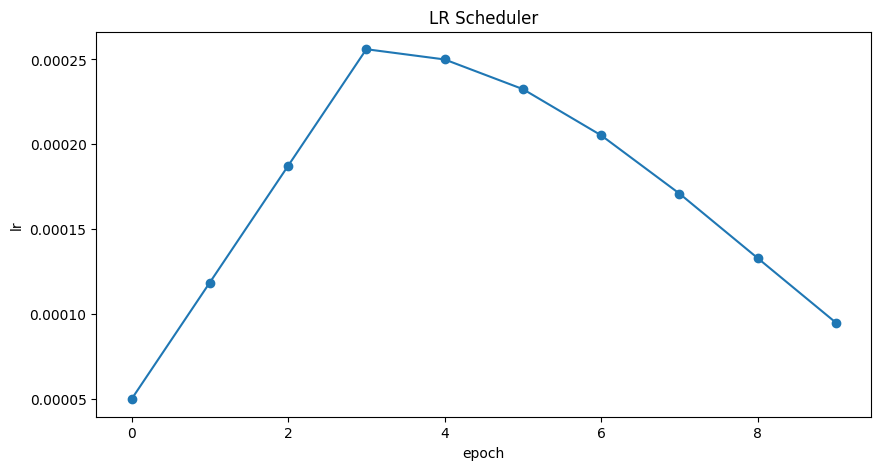

In [74]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

In [75]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.weights.h5",
                                         monitor='val_auc',
                                         save_weights_only=True,
                                         mode='max')

In [76]:
valid_ds

<_VariantDataset element_spec=(TensorSpec(shape=(32, 128, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 182), dtype=tf.float32, name=None))>

In [ ]:
if gpus:
    history = model.fit(
        valid_ds, 
        epochs=CFG.epochs,
        verbose=1
    )

Epoch 1/5


In [ ]:
model.predict(valid_ds)

In [ ]:
import librosa.display as lid

In [ ]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]), 
                     n_fft=CFG.nfft, 
                     hop_length=CFG.hop_length, 
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

In [ ]:
# CFG.augment = False

In [ ]:
#sample_ds = train_ds.take(1)

In [ ]:
#next(iter(sample_ds))

In [ ]:
s = valid_ds.take(1)
de = iter(s)
sr = next(de)
plot_batch(sr, label2name=CFG.label2name)

In [ ]:
plt.figure()
plt.plot(ag.numpy())

In [ ]:
trimmed_audio  = trim_audio(a_t)

In [ ]:
plt.figure()
plt.plot(trimmed_audio.numpy())

In [ ]:
a_t.shape

In [ ]:
a_t = tf.squeeze(trimmed_audio, axis=[-1])

In [ ]:
from IPython.display import Audio

Audio(a_t.numpy(), rate=rate.numpy())

## Remove background noise

In [ ]:
# !pip install pywavelets

In [ ]:
# import pywt

# def wavelet_denoising(audio_signal, wavelet='db4', level=1, threshold_mode='soft', threshold_value=0.1):
#     # Decompose audio signal into wavelet coefficients
#     coeffs = pywt.wavedec(audio_signal.numpy(), wavelet, level=level)
    
#     # Apply thresholding to each detail coefficient
#     for i in range(1, len(coeffs)):
#         coeffs[i] = pywt.threshold(coeffs[i], threshold_value, mode=threshold_mode)
    
#     # Reconstruct denoised signal from thresholded coefficients
#     denoised_signal = pywt.waverec(coeffs, wavelet)
    
#     return tf.convert_to_tensor(denoised_signal, dtype=tf.float32)

In [ ]:
# denoised_signal = wavelet_denoising(a_t,level=4)

In [ ]:
# plt.figure()
# plt.plot(trimmed_audio.numpy())

In [ ]:
# from IPython.display import Audio

# Audio(denoised_signal.numpy(), rate=rate.numpy())

In [ ]:
# plt.figure()
# plt.plot(denoised_signal.numpy())

In [ ]:
# plt.figure()
# plt.plot(trimmed_audio.numpy())